In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk 

In [3]:
data = pd.read_excel("América do Norte_MODEL.xlsx", sheet_name='Sheet1')

cat_col_minus_oh = ["sex", "student_accommodation", "work",
                    "sedentary_behavior", 'sedentary_2']

one_hotted = ["marital_status", "gender_identity", "sexual_orientation", "country_code"]                
target_col = "gad7_class"

data = data.drop(columns=["continent_code", "country_code", 
                          "income_grupos de referência pelo percentil_20,40,60,80,100"])

X = data.drop(columns=[target_col])
y = data[target_col]

missing_data_idx = X[X.isna().any(axis=1)].index.to_numpy()
complete_data_idx = X.dropna().index.to_numpy()

df = pd.DataFrame(data)
df.to_excel("América do Norte_MODEL_treated.xlsx", index=False)
df.describe()

,age,sex,gender_identity,sexual_orientation,bmi,marital_status,student_accommodation,work,score_food_smile,score_subs_smile,score_Physical Activity_smile,score_stress_smile,score_social_smile,score_sleep_smile,score_envir_smile,sedentary_behavior,sedentary_2,gad7_class
count,832.000000,832.000000,826.000000,829.000000,825.000000,830.000000,825.000000,830.000000,825.000000,822.000000,825.000000,833.000000,829.000000,826.000000,830.000000,833.000000,833.000000,833.000000
mean,18.545673,0.313702,0.021792,0.394451,23.143294,1.071084,0.739394,0.869880,7.990303,14.809002,8.461818,4.659064,7.375151,16.892252,9.487952,1.954382,1.165666,0.214886
std,1.250879,0.464276,0.146091,0.953011,4.155025,0.461818,0.439232,0.336639,1.478783,1.549434,2.211249,1.617651,2.873822,2.908589,2.083707,0.925251,1.085934,0.410990
min,16.000000,0.000000,0.000000,0.000000,15.059688,0.000000,0.000000,0.000000,4.000000,5.000000,3.000000,2.000000,3.000000,6.000000,2.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,20.415224,1.000000,0.000000,1.000000,7.000000,14.000000,7.000000,3.000000,6.000000,15.000000,8.000000,1.000000,0.000000,0.000000
50%,18.000000,0.000000,0.000000,0.000000,22.464927,1.000000,1.000000,1.000000,8.000000,15.000000,9.000000,5.000000,7.000000,17.000000,9.000000,2.000000,1.000000,0.000000
75%,19.000000,1.000000,0.000000,0.000000,25.000000,1.000000,1.000000,1.000000,9.000000,16.000000,10.000000,6.000000,9.000000,20.000000,11.000000,3.000000,2.000000,0.000000
max,33.000000,1.000000,1.000000,4.000000,55.799127,4.000000,1.000000,1.000000,12.000000,16.000000,14.000000,9.000000,62.000000,20.000000,16.000000,4.000000,4.000000,1.000000


array([[<Axes: title={'center': 'gad7_class'}>]], dtype=object)

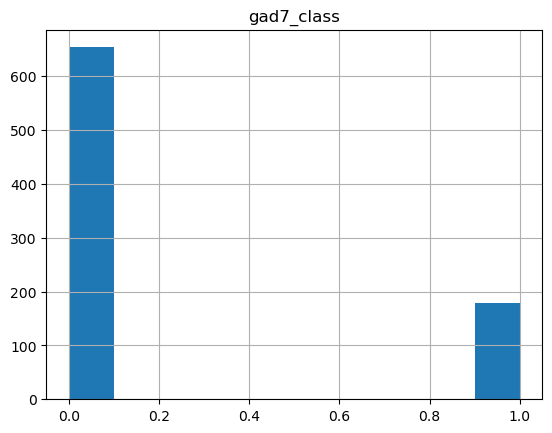

In [4]:
df.hist(["gad7_class"])

In [3]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=50)
splits = []

one_hotted = ["marital_status", "gender_identity", "sexual_orientation", 'sex', 'student_accommodation', 'work']  

#cat_noh = ['sex', 'student_accommodation', 'work', 'sedentary_behavior','sedentary_2','income_grupos de referência pelo percentil_20,40,60,80,100']

num = ['age', 'bmi', 'score_food_smile', 'score_subs_smile', 'score_Physical Activity_smile',
       'score_stress_smile', 'score_social_smile', 'score_sleep_smile',
       'score_envir_smile',  'sedentary_behavior','sedentary_2']

for train_pos, test_pos in shuffle_split.split(complete_data_idx):
    train_idx = complete_data_idx[train_pos]
    test_idx = complete_data_idx[test_pos]

    train_idx = pd.Index(train_idx).union(missing_data_idx)  

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # One-hot encoding e StandardScaler
    onehot_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    #scaler_transformer = MinMaxScaler(feature_range=(0, 1))
    scaler_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", onehot_transformer, one_hotted),
            ("scaler", scaler_transformer, num),
        ],
        remainder="passthrough"
    )

    #  codficando e escalonando
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    #nomeando as variáveis nos splits - melhor visualização
    onehot_names = preprocessor.named_transformers_["onehot"].get_feature_names_out(one_hotted)
    scaled_names = num

    remaining = [col for col in X_train.columns if col not in one_hotted + num]

    all_feature_names = np.concatenate([onehot_names, scaled_names, remaining])

    X_train = pd.DataFrame(X_train_transformed, index=X_train.index, columns=all_feature_names)
    X_test = pd.DataFrame(X_test_transformed, index=X_test.index, columns=all_feature_names)

    # guardando splits com os dados transformados
    splits.append({
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    })

# debugging: check do "transformer"
print(f"Treino: {splits[0]['X_train'].shape}, Teste: {splits[0]['X_test'].shape}")

Treino: (678, 33), Teste: (155, 33)


In [4]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=1)
for split in splits:

    X_train_imputed = pd.DataFrame(
        knn_imputer.fit_transform(split["X_train"]),
        columns=split["X_train"].columns,
        index=split["X_train"].index
    )

    split["X_train_imputed"] = X_train_imputed

In [5]:
from scipy.stats import ks_2samp, chi2_contingency
c2 = ['marital_status_0.0', 'marital_status_1.0', 'marital_status_2.0',
       'marital_status_3.0', 'marital_status_4.0', 'marital_status_nan',
       'gender_identity_0.0', 'gender_identity_1.0', 'gender_identity_nan',
       'sexual_orientation_0.0', 'sexual_orientation_1.0',
       'sexual_orientation_2.0', 'sexual_orientation_3.0',
       'sexual_orientation_4.0', 'sexual_orientation_nan', 'country_code_0',
       'country_code_1', 'country_code_2', 'country_code_3', 'country_code_4',
       'country_code_5', "sex_0.0",	"sex_1.0",	"sex_nan",	"student_accommodation_0.0",	
       "student_accommodation_1.0",	"student_accommodation_nan",	"work_0.0",	"work_1.0",	"work_nan"] 

ks = ['age', 'bmi', 'score_food_smile', 'score_subs_smile', 'score_Physical Activity_smile',
      'score_stress_smile', 'score_social_smile', 'score_sleep_smile', 'score_envir_smile', 
      'sedentary_behavior','sedentary_2']

for i, split in enumerate(splits):

    X_train_imputed = splits[i]["X_train_imputed"]

    #testando a similaridade dos dados inputados vs originais
    for col in split["X_train"].columns:
        #teste KS para variáveis numéricas
        if col in ks:
            original_values = split["X_train"][col].dropna()
            imputed_values = X_train_imputed[col]

            ks_stat, p_value = ks_2samp(original_values, imputed_values)

            if p_value < 0.05: print(f"Variável {col}  NÃO tem distribuições similares (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} NÃO tem distribuições similares (proved null-hypothesis) - {p_value}")

        #chi-quadrado para testar variação entre categóricas
        elif col in c2:
            original_counts = split["X_train"][col].value_counts()
            imputed_counts = X_train_imputed[col].round().astype(int).value_counts()

            original_counts= original_counts.reindex(imputed_counts.index, fill_value=0)
            imputed_counts= imputed_counts.reindex(original_counts.index, fill_value=0)

            chi2, p_value, _, _ = chi2_contingency([original_counts, imputed_counts])

            if p_value < 0.05: print(f"Variável {col} AFETADA pela inputação (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} AFETADA pela inputação (proved null-hypothesis) - {p_value}")

In [6]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
adasyn = RandomUnderSampler(random_state=42, sampling_strategy="all")
for split in splits:
    X_train, y_train = split["X_train_imputed"], split["y_train"]
    X_train_os, y_train_os = adasyn.fit_resample(X_train, y_train)

    split["X_train_os"], split["y_train_os"] = X_train_os, y_train_os

print("ok")

ok


In [7]:
from scipy.stats import ks_2samp, chi2_contingency
print("RandomUnderSampler")
c2 = ['marital_status_0.0', 'marital_status_1.0', 'marital_status_2.0',
       'marital_status_3.0', 'marital_status_4.0', 'marital_status_nan',
       'gender_identity_0.0', 'gender_identity_1.0', 'gender_identity_nan',
       'sexual_orientation_0.0', 'sexual_orientation_1.0',
       'sexual_orientation_2.0', 'sexual_orientation_3.0',
       'sexual_orientation_4.0', 'sexual_orientation_nan', 'country_code_0',
       'country_code_1', 'country_code_2', 'country_code_3', 'country_code_4',
       'country_code_5', "sex_0.0",	"sex_1.0",	"sex_nan",	"student_accommodation_0.0",	
       "student_accommodation_1.0",	"student_accommodation_nan",	"work_0.0",	"work_1.0",	"work_nan"] 

ks = ['age', 'bmi', 'income_grupos de referência pelo percentil_20,40,60,80,100', 
      'score_food_smile', 'score_subs_smile', 'score_Physical Activity_smile',
      'score_stress_smile', 'score_social_smile', 'score_sleep_smile',
      'score_envir_smile', 'sedentary_behavior','sedentary_2']

for i, split in enumerate(splits):

    X_train_os = splits[i]["X_train_os"]

    #testando a similaridade dos dados inputados vs originais
    for col in split["X_train_imputed"].columns:
        #teste KS para variáveis numéricas
        if col in ks:
            original_values = split["X_train_imputed"][col].dropna()
            smoted_values = X_train_os[col]

            ks_stat, p_value = ks_2samp(original_values, smoted_values)

            if p_value < 0.05: print(f"Variável {col}  NÃO tem distribuições similares (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} NÃO tem distribuições similares (proved null-hypothesis) - {p_value}")

        #chi-quadrado para testar variação entre categóricas
        elif col in c2:
            original_counts = split["X_train_imputed"][col].value_counts()
            smoted_counts = X_train_os[col].round().astype(int).value_counts()

            original_counts= original_counts.reindex(imputed_counts.index, fill_value=0)
            smoted_counts= smoted_counts.reindex(original_counts.index, fill_value=0)

            chi2, p_value, _, _ = chi2_contingency([original_counts, smoted_counts])

            if p_value < 0.05: print(f"Variável {col} AFETADA pelo over-sampling (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} AFETADA pela inputação (proved null-hypothesis) - {p_value}"
print("ok")

RandomUnderSampler
Variável sexual_orientation_0.0 AFETADA pelo over-sampling (failed null-hypothesis) - 0.03244682840808152
Variável sex_0.0 AFETADA pelo over-sampling (failed null-hypothesis) - 0.037240039078574476
Variável sex_1.0 AFETADA pelo over-sampling (failed null-hypothesis) - 0.04136995848843465
Variável score_social_smile  NÃO tem distribuições similares (failed null-hypothesis) - 0.04954459443532759
ok


/home/jvcha/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Split 1 -- Accuracy: 0.600, Recall: 0.641, F1: 0.542, F1-beta: 0.555
Split 2 -- Accuracy: 0.632, Recall: 0.576, F1: 0.562, F1-beta: 0.561
Split 3 -- Accuracy: 0.613, Recall: 0.579, F1: 0.552, F1-beta: 0.554
Split 4 -- Accuracy: 0.613, Recall: 0.625, F1: 0.547, F1-beta: 0.555
Split 5 -- Accuracy: 0.626, Recall: 0.616, F1: 0.557, F1-beta: 0.561

Overall Cross-Validation Metrics:
Average Accuracy: 0.617
Average Recall: 0.607
Average F1 Score: 0.552
Average F1-beta Score: 0.557


/tmp/ipykernel_572/782795740.py:100: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
/tmp/ipykernel_572/782795740.py:101: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()
/tmp/ipykernel_572/782795740.py:103: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
/tmp/ipykernel_572/782795740.py:104: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()


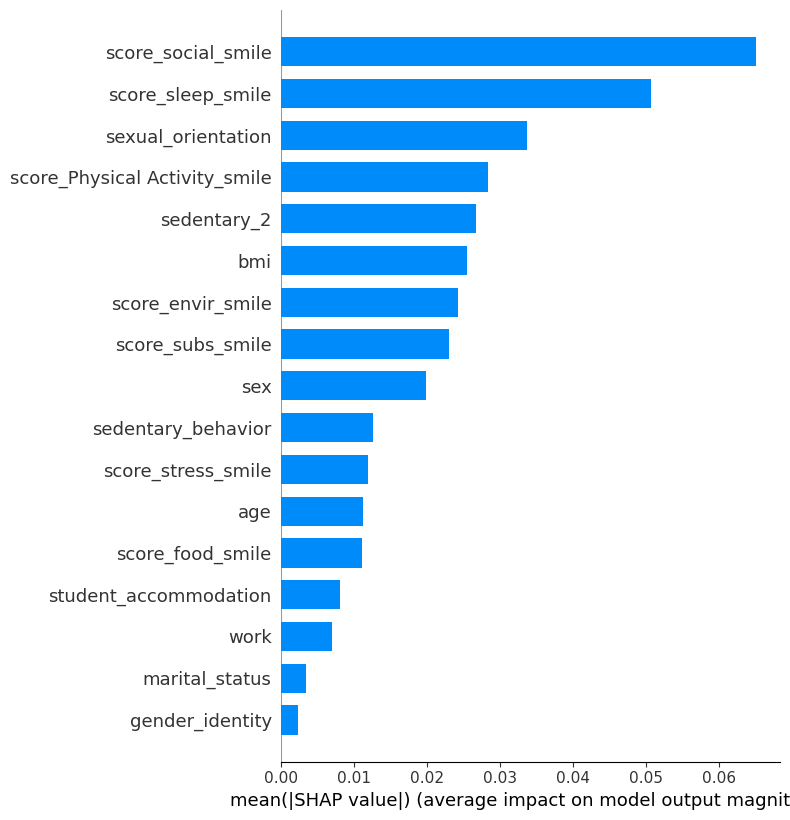

In [8]:
#RandomForest
one_hotted = ["marital_status", "gender_identity", "sexual_orientation", 
              "country_code", 'sex', 'student_accommodation', 'work'] 

lifestyle = ['score_subs_smile', 'score_Physical Activity_smile', 'score_stress_smile', 
             'score_social_smile', 'score_sleep_smile','score_envir_smile', 'score_food_smile']

social_var = ["marital_status", "gender_identity", "sexual_orientation", 
              'sex', 'student_accommodation', 'work', 'income_pct', 'sedentary_behavior' , 'sedentary_2']

def one_hot_agg(name):
    for prefix in one_hotted:
        if name.startswith(prefix):
            return prefix
    return name

def aggregate_col(col):
    if col in lifestyle:
        return 'lifestyle'
    elif col in social_var:
        return 'social_var'
    else:
        return col

import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

acc_list = []
recall_list = []
f1_list = []
f1_beta_list = []
all_y_true = []
all_predictions = []
all_shap_values = []

for i, split in enumerate(splits):

    X_train = split['X_train_os']
    X_test = split['X_test']
    y_train = split['y_train_os']
    y_test = split['y_test']

#    columns = splits[0]["X_test"].columns
#    X_test = pd.DataFrame(X_test, columns=columns)
#    X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

#   escrevi aqui os valores dos hiperparametros que utilizei, mais para guardar um histórico
#   GridSearch 1: (max_depth=10, min_samples_split=10, n_estimators=200) - 0.422

    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train, y_train)
    predictions = clf_rf.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    f1_beta = fbeta_score(y_test, predictions, beta=0.5, average='macro')
    
    print(f"Split {i+1} -- Accuracy: {acc:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F1-beta: {f1_beta:.3f}")

    acc_list.append(acc)
    recall_list.append(recall)
    f1_list.append(f1)
    f1_beta_list.append(f1_beta)
    
    all_y_true.extend(y_test)
    all_predictions.extend(predictions)

    explainer = shap.TreeExplainer(clf_rf)
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    for SHAPs in shap_values:
        all_shap_values.append(SHAPs)

avg_acc = np.mean(acc_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_f1_beta = np.mean(f1_beta_list)

print("\nOverall Cross-Validation Metrics:")
print("Average Accuracy: {:.3f}".format(avg_acc))
print("Average Recall: {:.3f}".format(avg_recall))
print("Average F1 Score: {:.3f}".format(avg_f1))
print("Average F1-beta Score: {:.3f}".format(avg_f1_beta))

## Compute and display the overall confusion matrix
#cm = confusion_matrix(all_y_true, all_predictions, labels=clf_rf.classes_)
#mtx = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
#mtx.plot(cmap="YlGnBu")
#plt.show()

columns = splits[0]["X_train_imputed"].columns
X_test = pd.DataFrame(X_test, columns=columns)
X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

shap_df = pd.DataFrame(shap_values[:, :, 1], columns = X_test.columns)
shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()

shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()

# Now call the SHAP summary plot with matching shapes:
shap.summary_plot(shap_df_agg.values, X_test_agg, max_display=50, plot_type="bar")

Split 1
 -- Train Accuracy x Test Accuracy: 0.954 x 0.797
 -- Train Recall x Test Recall: 0.929 x 0.617
 -- Train ROC AUC x Test ROC AUC: 0.990 x 0.741
Split 2
 -- Train Accuracy x Test Accuracy: 0.952 x 0.764
 -- Train Recall x Test Recall: 0.940 x 0.593
 -- Train ROC AUC x Test ROC AUC: 0.987 x 0.764
Split 3
 -- Train Accuracy x Test Accuracy: 0.939 x 0.789
 -- Train Recall x Test Recall: 0.930 x 0.630
 -- Train ROC AUC x Test ROC AUC: 0.983 x 0.629
Split 4
 -- Train Accuracy x Test Accuracy: 0.949 x 0.756
 -- Train Recall x Test Recall: 0.925 x 0.504
 -- Train ROC AUC x Test ROC AUC: 0.986 x 0.709
Split 5
 -- Train Accuracy x Test Accuracy: 0.941 x 0.724
 -- Train Recall x Test Recall: 0.923 x 0.547
 -- Train ROC AUC x Test ROC AUC: 0.984 x 0.653

Overall Cross-Validation Metrics:
Average Accuracy: 0.947 x 0.766
Average Recall: 0.930 x 0.578
Average AUC-SCORE: 0.986 x 0.699


C:\Users\jvcha\AppData\Local\Temp\ipykernel_19912\1704166216.py:131: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
C:\Users\jvcha\AppData\Local\Temp\ipykernel_19912\1704166216.py:132: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()
C:\Users\jvcha\AppData\Local\Temp\ipykernel_19912\1704166216.py:134: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
C:\Users\jvcha\AppData\Local\Temp\ipykernel_19912\1704166216.py:135: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()


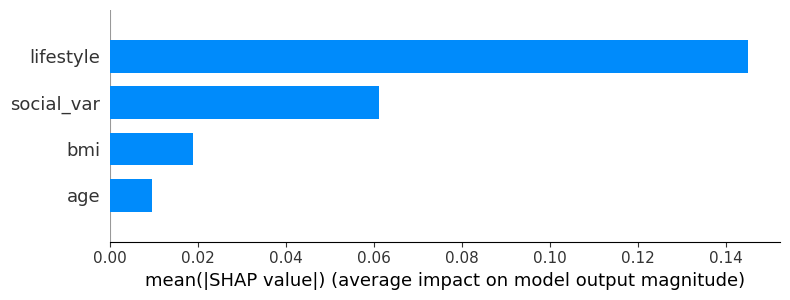

In [10]:
#RandomForest - teste sem imputação/balanceamento
one_hotted = ["marital_status", "gender_identity", "sexual_orientation", 
              "country_code", 'sex', 'student_accommodation', 'work'] 

lifestyle = ['score_subs_smile', 'score_Physical Activity_smile', 'score_stress_smile', 
             'score_social_smile', 'score_sleep_smile','score_envir_smile', 'score_food_smile']

social_var = ["marital_status", "gender_identity", "sexual_orientation", 
              'sex', 'student_accommodation', 'work', 'income_pct', 'sedentary_behavior' , 'sedentary_2']

def one_hot_agg(name):
    for prefix in one_hotted:
        if name.startswith(prefix):
            return prefix
    return name

def aggregate_col(col):
    if col in lifestyle:
        return 'lifestyle'
    elif col in social_var:
        return 'social_var'
    else:
        return col

import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.decomposition import PCA

acc_train_list,  acc_test_list = [], []
recall_train_list, recall_test_list = [], []
roc_auc_train_list, roc_auc_test_list = [], []
all_y_true = []
all_predictions = []
all_shap_values = []

for i, split in enumerate(splits):
    
    X_train = split["X_train_imputed"]
    X_test = split['X_test']
    y_train = split["y_train"]
    y_test = split['y_test']
    
#    columns = splits[0]["X_test"].columns
#    X_test = pd.DataFrame(X_test, columns=columns)
#    X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

#   escrevi aqui os valores dos hiperparametros que utilizei, mais para guardar um histórico
#   GridSearch 1: (max_depth=10, min_samples_split=10, n_estimators=200) - 0.422

    clf_rf = RandomForestClassifier(
                                    n_estimators=150,
                                    max_depth=None,
                                    min_samples_split=5,
                                    min_samples_leaf=4,
                                    max_features='sqrt',
                                    class_weight='balanced',
                                    criterion='entropy',
                                    bootstrap=True)
    clf_rf.fit(X_train, y_train)
    
    pred_test = clf_rf.predict(X_test)
    pred_train = clf_rf.predict(X_train)
    
    y_train_pred_prob = clf_rf.predict_proba(X_train)[:, 1]
    y_test_pred_prob = clf_rf.predict_proba(X_test)[:, 1]

    acc_test = accuracy_score(y_test, pred_test)
    acc_train = accuracy_score(y_train, pred_train)
    
    recall_test = recall_score(y_test, pred_test, average='macro')
    recall_train = recall_score(y_train, pred_train, average='macro')
    
    #f1 = f1_score(y_test, predictions, average='macro')
    #f1_beta = fbeta_score(y_test, predictions, beta=0.5, average='macro')

    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    #print(f"Split {i+1} -- Accuracy: {acc:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, F1-beta: {f1_beta:.3f}, ROC-AUC: {roc_auc:.3f}")
    print(f"Split {i+1}")
    print(f" -- Train Accuracy x Test Accuracy: {acc_train:.3f} x {acc_test:.3f}")
    print(f" -- Train Recall x Test Recall: {recall_train:.3f} x {recall_test:.3f}")
    print(f" -- Train ROC AUC x Test ROC AUC: {train_auc:.3f} x {test_auc:.3f}")

    acc_test_list.append(acc_test)
    acc_train_list.append(acc_train)
    recall_test_list.append(recall_test)
    recall_train_list.append(recall_train)
    #f1_list.append(f1)
    #f1_beta_list.append(f1_beta)
    roc_auc_test_list.append(test_auc)
    roc_auc_train_list.append(train_auc)
    
#    all_y_true.extend(y_test)
#    all_predictions.extend(predictions)

    explainer = shap.TreeExplainer(clf_rf)
    shap_values = explainer.shap_values(X_test, check_additivity=False)
    for SHAPs in shap_values:
        all_shap_values.append(SHAPs)

avg_acc_train, avg_acc_test = np.mean(acc_train_list), np.mean(acc_test_list)
avg_recall_train, avg_recall_test = np.mean(recall_train_list), np.mean(recall_test_list)
#avg_f1 = np.mean(f1_list)
#avg_f1_beta = np.mean(f1_beta_list)
avg_roc_auc_score_train, avg_roc_auc_score_test = np.mean(roc_auc_train_list), np.mean(roc_auc_test_list)

print("\nOverall Cross-Validation Metrics:")
print(f"Average Accuracy: {avg_acc_train:.3f} x {avg_acc_test:.3f}")
print(f"Average Recall: {avg_recall_train:.3f} x {avg_recall_test:.3f}")
print(f"Average AUC-SCORE: {avg_roc_auc_score_train:.3f} x {avg_roc_auc_score_test:.3f}")
          
#print("Average Recall: {:.3f}".format(avg_recall))
#print("Average F1 Score: {:.3f}".format(avg_f1))
#print("Average F1-beta Score: {:.3f}".format(avg_f1_beta))
#print("Average ROC-AUC score: {:.3f}".format(avg_roc_auc_score))

## Compute and display the overall confusion matrix
#cm = confusion_matrix(all_y_true, all_predictions, labels=clf_rf.classes_)
#mtx = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
#mtx.plot(cmap="YlGnBu")
#plt.show()

columns = splits[0]["X_train_imputed"].columns
X_test = pd.DataFrame(X_test, columns=columns)
X_test.rename(columns={'income_grupos de referência pelo percentil_20,40,60,80,100': 'income_pct'}, inplace=True)

shap_df = pd.DataFrame(shap_values[:, :, 1], columns = X_test.columns)
shap_df_agg = shap_df.groupby(one_hot_agg, axis=1).sum()
X_test_agg = X_test.groupby(one_hot_agg, axis=1).first()

shap_df_aggregated = shap_df_agg.groupby(aggregate_col, axis=1).sum()
X_test_aggregated = X_test_agg.groupby(aggregate_col, axis=1).first()

# Now call the SHAP summary plot with matching shapes:
shap.summary_plot(shap_df_aggregated.values, X_test_aggregated, max_display=50, plot_type="bar")

In [9]:
#Naive-Bayes
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import recall_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin

recall_scorer = make_scorer(recall_score, average='macro')

smote = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=1)

recall_scores = []
best_params_list = []

pipeline = Pipeline([
    ('rf',  RandomForestClassifier())
])
        
param = {
    'rf__n_estimators': [50, 100, 200, 300, 500],
    'rf__max_depth': [None, 10, 20, 30, 50, 70],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy']
}

for i, split in enumerate(splits):
    X_train = split['X_train_os']
    y_train = split['y_train_os']
    X_test = split['X_test']
    y_test = split['y_test']

    X_train_rs, y_train_rs = smote.fit_resample(X_train, y_train)
    
    bayes_cv = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param,
        cv=5,                            # 3-fold cross-validation
        n_iter=10,                       # number of parameter settings to try
        scoring=recall_scorer,              # or another scoring metric as needed
        random_state=42
    )

    bayes_cv.fit(X_train_rs, y_train_rs)
    best_params_list.append(bayes_cv.best_params_)
    
    predictions = bayes_cv.predict(X_test)
    best_recall = recall_score(y_test, predictions, average='macro')
    recall_scores.append(best_recall)
    print(f"Split {i+1} - Best Parameters: {bayes_cv.best_params_}, Recall: {best_recall:.3f}")

avg_recall = sum(recall_scores) / len(recall_scores)
print(f"\nOverall Average Recall: {avg_recall:.3f}")


Split 1 - Best Parameters: OrderedDict({'rf__bootstrap': True, 'rf__criterion': 'entropy', 'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}), Recall: 0.633
Split 2 - Best Parameters: OrderedDict({'rf__bootstrap': True, 'rf__criterion': 'entropy', 'rf__max_depth': 70, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}), Recall: 0.618
Split 3 - Best Parameters: OrderedDict({'rf__bootstrap': True, 'rf__criterion': 'entropy', 'rf__max_depth': 50, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}), Recall: 0.541
Split 4 - Best Parameters: OrderedDict({'rf__bootstrap': True, 'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}), Recall: 0.605
Split 5 - Best Parameters: OrderedDict({'rf__bootstrap'